In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%load_ext line_profiler

In [3]:
import json
import os
import sys
sys.path.insert(0, os.path.abspath('./src/'))

import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
from predict import Model
from predict import load_data
from utils import imsetshow

## 1.0 Configuration

Changed the batch size to 16 due to memory limits. 

In [7]:
config_file_path = "./config/config.json"
with open(config_file_path, "r") as read_file:
    config = json.load(read_file)
    
checkpoint_dir = config["paths"]["checkpoint_dir"]
run_subfolder = 'batch_16_views_32_min_32_beta_50.0_time_2020-01-19-13-15-10-475736'
checkpoint_filename = 'HRNet.pth'
checkpoint_file = os.path.join( checkpoint_dir, run_subfolder, checkpoint_filename)
# print(checkpoint_file)
assert os.path.isfile(checkpoint_file)

## 1.1 Load model

In [8]:
model = Model(config)
model.load_checkpoint(checkpoint_file=checkpoint_file)

## 1.2 Load data

In [9]:
train_dataset, val_dataset, test_dataset, baseline_cpsnrs = load_data(config_file_path, val_proportion=0.10, top_k=-1)

## 1.3 Run evaluation

In [10]:
results = model.evaluate(train_dataset, val_dataset, test_dataset, baseline_cpsnrs)

## 1.4 Benchmark % ESA Baseline

In [11]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

In [12]:
results.part.value_counts()

train    1044
test      290
val       116
Name: part, dtype: int64

In [13]:
results.describe().T

,count,mean,std,min,25%,50%,75%,max
ESA,"1,450.00",46.38,3.78,31.45,43.94,46.31,48.65,59.72
model,"1,160.00",49.20,3.47,39.06,46.80,49.08,51.32,60.93
score,"1,160.00",0.94,0.03,0.79,0.93,0.95,0.96,1.06
mean_clr,"1,450.00","3,882,205.99","190,040.65","2,340,645.00","3,815,749.17","3,916,757.30","4,009,717.68","4,158,178.06"
std_clr,"1,450.00","374,248.35","115,999.73","43,936.62","303,676.63","384,557.24","455,747.18","1,046,887.10"


In [14]:
results.loc[results['part'] == 'train'].describe().loc['mean']

ESA               46.46
model             49.22
score              0.94
mean_clr   3,873,590.84
std_clr      378,809.12
Name: mean, dtype: float64

Achieved a mean score of 0.95. Code is based on the 1st rank solution. a.k.a. `rarefin`. 0.95 is somewhere around 3rd rank. The difference is due to different batch size.

Model files and submission folder is in [GDrive](https://drive.google.com/open?id=1_3EOSK9yiQ1CEhADJnxpo6H8vWkhcvKh)

In [15]:
results.loc[results['part'] == 'val'].describe().loc['mean']

ESA               46.77
model             49.00
score              0.95
mean_clr   3,900,070.57
std_clr      381,392.16
Name: mean, dtype: float64

In [16]:
results.loc[results['part'] == 'test'].describe().loc['mean']

ESA               45.94
model               nan
score               nan
mean_clr   3,906,074.72
std_clr      354,972.05
Name: mean, dtype: float64

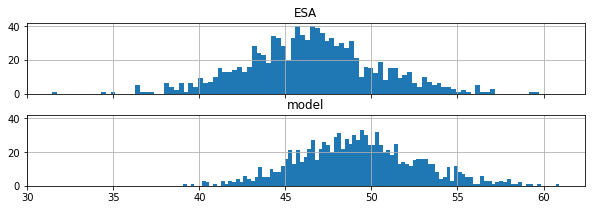

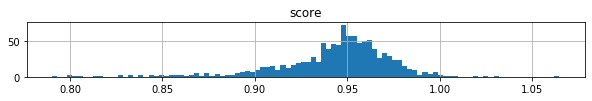

In [17]:
results.loc[results['part']=='train'].hist(column=['ESA', 'model'],
                                           sharex=True, sharey=True, bins=100, layout=(2,1), figsize=(10, 3));
results.loc[results['part']=='train'].hist(column=['score'],
                                           bins=100, figsize=(10, 1));

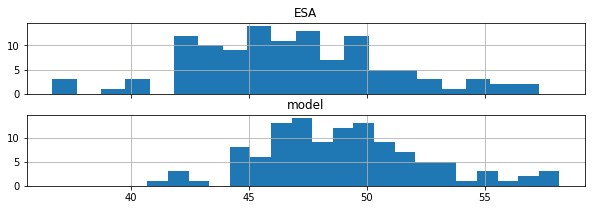

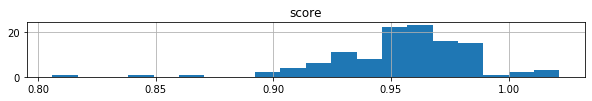

In [18]:
results.loc[results['part']=='val'].hist(column=['ESA', 'model'],
                                           sharex=True, sharey=True, bins=20, layout=(2,1), figsize=(10, 3));
results.loc[results['part']=='val'].hist(column=['score'],
                                           bins=20, figsize=(10, 1));

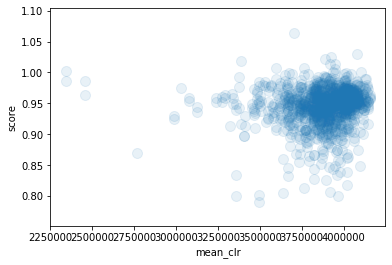

In [19]:
results.plot.scatter('mean_clr', 'score', s=100, alpha=.1);

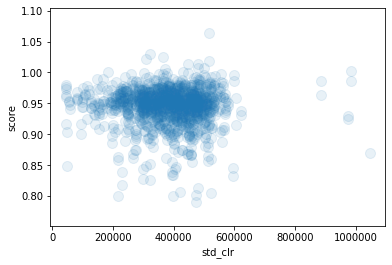

In [20]:
results.plot.scatter('std_clr', 'score', s=100, alpha=.1);

## 1.5 Pretty pics

In [21]:
results[results['part'] == 'val'].sort_values('score')

,ESA,model,clr,part,score,mean_clr,std_clr
imgset0873,37.64,46.71,"[4177920, 4170525, 4150125, 4146045, 4145535, ...",val,0.81,"3,916,872.86","419,706.32"
imgset0099,39.63,46.94,"[4126155, 4119780, 4106010, 4101420, 4065720, ...",val,0.84,"3,820,623.87","298,308.59"
imgset0257,43.60,50.47,"[4172820, 4170015, 4165425, 4165170, 4161855, ...",val,0.86,"3,792,615.00","511,754.75"
imgset0549,37.59,42.10,"[4177920, 4177665, 4177155, 4163640, 4161855, ...",val,0.89,"3,742,185.00","452,056.35"
imgset0802,36.67,40.70,"[4159050, 4142730, 4140945, 4138140, 4135845, ...",val,0.90,"3,907,950.56","397,236.69"
...,...,...,...,...,...,...,...
imgset0366,48.23,48.21,"[4177920, 4177920, 4177920, 4177920, 4177920, ...",val,1.00,"4,106,364.17","181,797.00"
imgset0695,44.85,44.55,"[4177920, 4177920, 4177920, 4177920, 4177920, ...",val,1.01,"3,765,563.75","501,321.75"
imgset0265,50.08,49.41,"[4177920, 4177920, 4177920, 4177920, 4177920, ...",val,1.01,"3,950,506.36","447,169.36"
imgset0982,53.11,52.40,"[4177920, 4177920, 4177920, 4177920, 4177920, ...",val,1.01,"3,920,540.00","480,870.76"


In [22]:
iter_over_ims = iter(val_dataset)

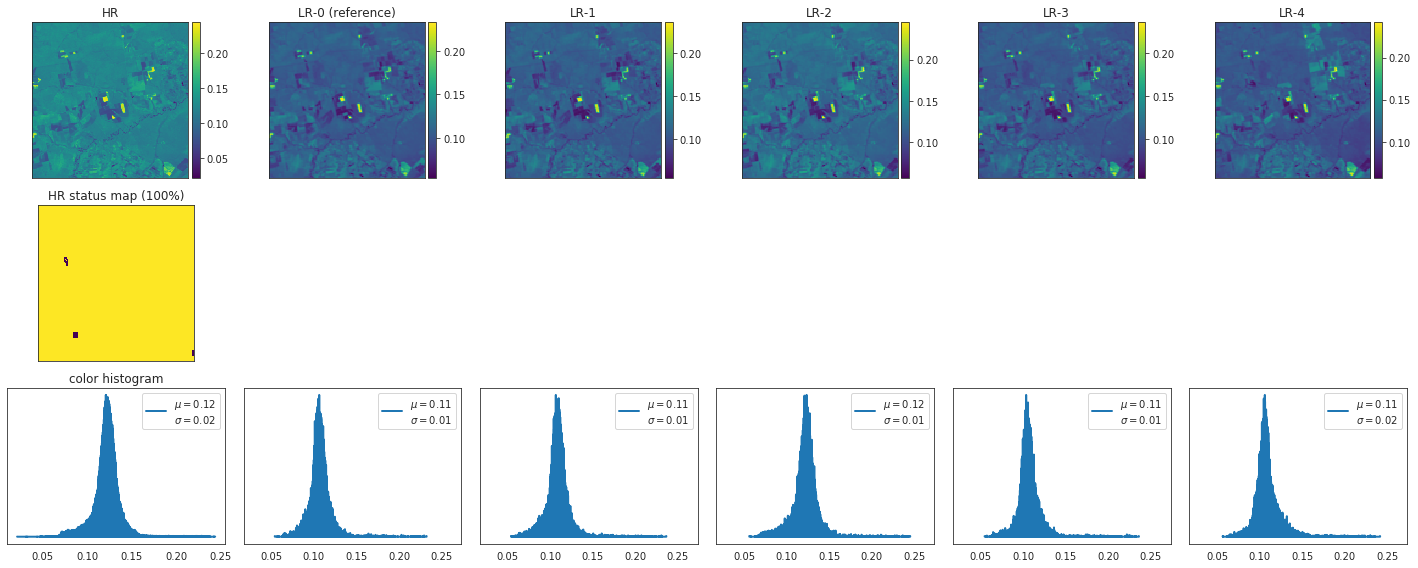

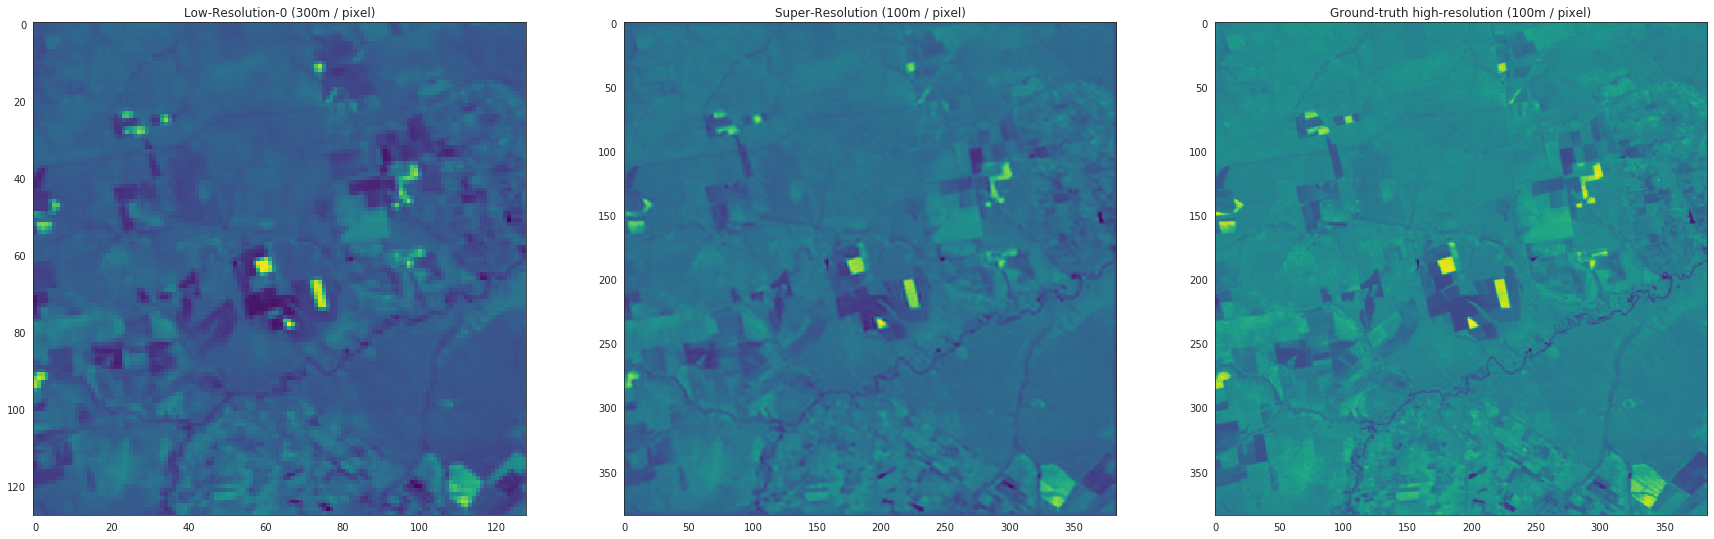

In [23]:
imset = iter_over_ims.__next__()
sr, scPSNR = model(imset)

imsetshow(imset, k=5, figsize=(20,8), resample=False, show_histogram=True, show_map=True)

plt.figure(figsize=(30, 10))
plt.subplot(131);  plt.imshow(imset['lr'][0]);  plt.title('Low-Resolution-0 (300m / pixel)');
plt.subplot(132);  plt.imshow(sr);  plt.title('Super-Resolution (100m / pixel)');
plt.subplot(133);  plt.imshow(imset['hr']);  plt.title('Ground-truth high-resolution (100m / pixel)');

## 1.6 Generate submission file

In [24]:
model.generate_submission_file(imset_dataset=test_dataset, out='./submission')

generating solutions: 

**************************************************************************************************************************************************************************************************************************************************************************************************

archiving: 
**************************************************************************************************************************************************************************************************************************************************************************************************
done. The submission-file is found at ./submission/submission.zip.
